# Build tech tree
Grace Deng, August 2020 <br />
Updated by Natalia Velez, April 2021

In [1]:
%matplotlib inline

import os, re, glob, json
from os.path import join as opj
import numpy as np
import pandas as pd
import json
import pymongo
from tqdm import notebook

# Debug: Estimate time needed to run job
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

# Debug: Embed html-formatted text
# (Used to do QA on transitions)
from IPython.core.display import display, HTML
def embed(s): return display(HTML(s))

## Load game data from database

Connect:

In [2]:
keyfile = '../6_database/credentials.key'

#Connection string
creds = open(keyfile, "r").read().splitlines()
myclient = pymongo.MongoClient('134.76.24.75', username=creds[0], password=creds[1], authSource='ohol') 
print(myclient)

ohol = myclient.ohol
print(ohol)

MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol')
Database(MongoClient(host=['134.76.24.75:27017'], document_class=dict, tz_aware=False, connect=True, authsource='ohol'), 'ohol')


Objects:

In [3]:
objects = list(ohol.objects.find())
objects = pd.DataFrame(objects)

print('Loading %i objects' % objects.shape[0])
objects.head()

Loading 4161 objects


,_id,id,name,containable,containSize,vertSlotRot,permanent,minPickupAge,heldInHand,blocksWalking,...,floorHugging,slotsLocked,noFlip,sideAccess,creationSoundForce,invisCont,slotPos,vert,spritesDrawnBehind,spritesAdditiveBlend
0,60750c9e68dcd62afd70767e,11,Skin Tone A &B &C &D &E &F,0,1.0,0.0,0,3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60750c9e68dcd62afd70767f,19,Female001 D,0,1.0,0.0,0,3,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,60750c9e68dcd62afd707680,30,Wild Gooseberry Bush,0,1.0,0.0,1,3,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,60750c9e68dcd62afd707681,31,Gooseberry,1,1.0,0.0,0,3,1,0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,60750c9e68dcd62afd707682,32,Big Hard Rock,0,1.0,0.0,1,3,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Transitions:

In [4]:
transitions = list(ohol.expanded_transitions.find())
transitions = pd.DataFrame(transitions)

print('Loading %i transitions' % transitions.shape[0])
transitions.head()

Loading 19445 transitions


,_id,origActor,origTarget,newActor,newTarget,lastUseActor,lastUseTarget,prob
0,607aef65cffb881ebaafdd44,-1,1968,0,1969,False,False,True
1,607aef65cffb881ebaafdd45,-1,1968,0,1972,False,False,True
2,607aef65cffb881ebaafdd46,-1,1968,0,1970,False,False,True
3,607aef65cffb881ebaafdd47,-1,1968,0,1971,False,False,True
4,607aef65cffb881ebaafdd48,-1,1968,0,1973,False,False,True


In [23]:
transitions[paths_to(143)]

,_id,origActor,origTarget,newActor,newTarget,lastUseActor,lastUseTarget,prob
95,607aef65cffb881ebaafdda3,-2,141,0,143,False,False,False
3521,607aef65cffb881ebaafeb05,209,143,210,143,False,False,False
3631,607aef65cffb881ebaafeb73,235,143,382,143,False,False,False


In [22]:
transitions[transitions.origTarget == 141]

,_id,origActor,origTarget,newActor,newTarget,lastUseActor,lastUseTarget,prob
95,607aef65cffb881ebaafdda3,-2,141,0,143,False,False,False
137,607aef65cffb881ebaafddcd,-1,141,0,141,False,False,False
3400,607aef65cffb881ebaafea8c,152,141,151,510,False,False,False
3517,607aef65cffb881ebaafeb01,209,141,210,141,False,False,False
3518,607aef65cffb881ebaafeb02,209,141,210,512,False,True,False
3627,607aef65cffb881ebaafeb6f,235,141,382,141,False,False,False
3628,607aef65cffb881ebaafeb70,235,141,382,512,False,True,False


Helper functions: Querying object, transition data

In [5]:
### Read from object data
def obj_name(i):
    if i in [0, -1]:
        return 'empty'
    else:
        return objects[objects.id == i].name.values[0]

### Read from transition data
def paths_from(i):
    '''
    Get all uses for object i
    '''
    return (transitions['origActor'] == i) | (transitions['origActor'] == i)

def paths_to(i):
    '''
    Get all paths that produce object i
    (When we build the tech tree, we're going to make the shortest of these paths
    the official 'recipe' for i and use it to calculate the depth of i) 
    '''
    is_product = (transitions['newActor'] == i) | (transitions['newTarget'] == i)
    is_ingredient = paths_from(i)    
    
    return is_product & (~is_ingredient)

def combinations(obj1, obj2):
    '''
    Gets all transitions involving obj1 and obj2, regardless of their relative positions
    '''
    obj1_actor = (transitions['origActor'] == obj1) & (transitions['origTarget'] == obj2)
    obj2_actor = (transitions['origActor'] == obj2) & (transitions['origTarget'] == obj1)   
    
    return obj1_actor | obj2_actor

### Display outputs nicely
trans_cols = ['origActor', 'origTarget', 'newActor', 'newTarget']
def record_transition(row):
    '''
    Converts row in transition df into a mongo-friendly dictionary
    '''
    return row[trans_cols].to_dict()
    

def display_transition(row):
    '''
    Displays transitions in pretty, HTML-formatted text
    '''
    # Get item names
    names = row[trans_cols].apply(obj_name)
    
    # Generate HTML tags
    tag = '<mark style="background-color: %s;">%s</mark>'
    actor_color = '#91d8f2'
    target_color = '#ffbf6b'
    out = '(%s,%s) &#x2192; (%s,%s)' % (tag % (actor_color, names['origActor']),
                                        tag % (target_color, names['origTarget']),
                                        tag % (actor_color, names['newActor']),
                                        tag % (target_color, names['newTarget']))
    
    embed(out)

Helper functions in action:

In [6]:
print(obj_name(72))

print('=== USES ===')
for _, row in transitions[paths_from(72)].iterrows():
    display_transition(row)

print('=== HOW TO GET ===')
for _, row in transitions[paths_to(72)].iterrows():
    display_transition(row)

Kindling
=== USES ===


=== HOW TO GET ===


## Search through Tech tree

Initialize Tech tree dictionary:

In [7]:
tech_dict = {o:None for o in objects.id.values}

Start with natural objects:

In [8]:
nat_objs = objects[objects.mapChance > 0].id.values.tolist()
#nat_objs = [32, 33, 63, 153, 50] # DEBUG: Constrained set of natural objects
print('== Starting from %i natural items ==' % len(nat_objs))
print(*['%s (%i)' %(obj_name(o), o) for o in nat_objs], sep='\n')

== Starting from 80 natural items ==
Wild Gooseberry Bush (30)
Big Hard Rock (32)
Stone (33)
Seeding Wild Carrot (36)
Juniper Tree (49)
Milkweed (50)
Maple Tree -Branch (63)
Lombardy Poplar Tree -Branch (65)
White Pine Tree (99)
White Pine Tree with Needles (100)
Tule Reeds (121)
Clay Deposit (125)
Flint (133)
Sapling (136)
Yew Tree -Branch (153)
Rabbit Hole -hiding &single (161)
Fertile Soil Deposit (211)
Ripe Wheat (242)
Flat Rock - empty (291)
Wolf (418)
Willow Tree (527)
Bald Cypress Tree (530)
Mouflon (531)
Bear Cave (630)
Limestone (674)
Gold Vein (680)
Penguin (703)
Ice Hole (706)
Antarctic Fur Seal (707)
Indigo (713)
Rose Madder (714)
Alum (729)
Dead Tree (760)
Barrel Cactus (761)
Rattle Snake (764)
Wild Horse (769)
Monolith (791)
Burdock (804)
Wild Onion (805)
Muddy Iron Vein - gridPlacement40 &40 (942)
Wild Rose with Fruit (1013)
Snow Bank (1020)
Teosinte (1107)
Wild Potato (1140)
Wild Bean Plant (1157)
Wild Squash Plant (1184)
Wild Cabbage (1203)
Canada Goose Pond with Egg (

Search iteratively through Tech tree

(Note: This is pretty inefficient, as we repeatedly test the same combinations - fix before scaling up?)

In [9]:
# Initialize values
known_objs = [0, -1] + nat_objs
tech_tree = {o: {'depth': 0, 'recipe': None} for o in known_objs}
counter = 1
n_new = len(known_objs)
combos = [(o_i, o_j) 
          for i,o_i in enumerate(known_objs)
          for j,o_j in enumerate(known_objs[i:])]

# DEBUG: Time each iteration through tech tree
iter_timer = []

while n_new > 0:
# while counter < 7: # DEBUG: Limit search
    print('=== ITERATION %i ===' % counter)
    start = time.time()
    
    # Search for viable combinations
    product_list = [transitions[combinations(o_i, o_j)] for o_i, o_j in combos]
    product_df = pd.concat(product_list)
    
    # Which combinations yield new products?
    new_objs = []
    for _, row in product_df.iterrows():
        for e in ['newActor', 'newTarget']:
            product = row[e]
            
            # New products are added to the tech tree
            if product not in tech_tree.keys():
                print('%s (%i)' % (obj_name(product), product))
                new_objs.append(product)
                tech_tree[product] = {}
                tech_tree[product]['recipe'] = record_transition(row)
                
                # Calculate parents' depth
                parents = row[['origActor', 'origTarget']].tolist()
                parents_depth = max([tech_tree[p]['depth'] for p in parents])
                
                # Don't add difficulty for decay transitions
                if -1 in parents:
                    tech_tree[product]['depth'] = parents_depth
                else:
                    tech_tree[product]['depth'] = parents_depth + 1 
                
    # Prepare for next iteration
    counter += 1
    n_new = len(new_objs)
    
    # Update combinations in search space    
    if n_new > 0:
        combo_old = [(o_i, o_j) for o_i in known_objs for o_j in new_objs]
        combo_new = [(o_i, o_j) for i,o_i in enumerate(new_objs) for j,o_j in enumerate(new_objs[i:])]
        combos = combo_old + combo_new
        known_objs += new_objs
    else:
        print('(None found)')
    
    iter_timer.append(time.time()-start)

=== ITERATION 1 ===
Gooseberry (31)
Empty Wild Gooseberry Bush (279)
Carrot Seed Head (395)
Wild Carrot (404)
Juniper Tinder (61)
Milkweed Stalk (57)
Milkweed Debris (53)
Straight Branch (64)
Maple Tree (48)
Small Curved Branch (66)
Lombardy Poplar Tree (45)
Pine Needles (96)
Clay (126)
Clay Pit -partial (409)
Yew Branch (132)
Yew Tree (406)
Wheat Seed Head (223)
Attacking Wolf (427)
Bite Wound (1363)
Attacking Rattle Snake (1385)
Snake Bite (1377)
Wild Onion (808)
Wild Rose Hip (1015)
Wild Rose - picked (1014)
Snowball - +noWait (2407)
Teosinte Seed Head (1108)
Bare Teosinte (1123)
Dry Bean Pod (1160)
Empty Wild Bean Plant (1158)
Wild Squash (1183)
Empty Wild Squash Plant (1185)
Cold Goose Egg (1262)
Canada Goose Pond (141)
Attacking Wild Boar (1333)
Hog Cut (1364)
Mango Leaf (1878)
Banana (2143)
Empty Banana Plant (2145)
Mosquito Swarm -just bit (2157)
Yellow Fever - sick emot_7_35  food_0.3 fever_15 (2155)
Wild Tomato Cluster (2801)
Empty Wild Tomato Plant (2803)
Wild Pepper (2807)


Paving Direction East (4455)
Wormless Soil Pit (788)
Shaky Property Gate - +tempOwned +causeAutoOrientH (2983)
Open Pine Door - installed +horizontalOpenDoorPine +cornerOpenDoorPine (119)
Rabbit Family Hole -peeking1 (193)
Snowman Remnants - 4 (2423)
Property Fence - +horizontalD (2959)
Property Gate - +owned +causeAutoOrientH (2962)
Melting Snowman - 3 (2734)
Baited Snared Rabbit Hole -peeking1 &single (169)
Baited Snared Rabbit Family Hole -peeking1 (172)
Free-standing Corner Wall Stakes (110)
Dry Planted Carrots (396)
Smoldering Tinder (78)
Dry Planted Wheat (228)
Dry Planted Wild Onion (2845)
Dry Planted Corn Seed (1109)
Dry Planted Beans (1161)
Dry Planted Dill Seeds (4244)
Dry Planted Wild Garlic (4253)
Dry Planted Potatoes (1145)
Hyphen (948)
Dry Planted Cabbage Seed (1207)
Dry Planted Squash Seeds (1192)
Dry Planted Milkweed Seed (214)
Snow Wall - Arctic Only - +biomeReq4 +verticalSnow (3267)
Dry Planted Gooseberry Seed -fertile (216)
Partial Adobe Wall - +verticalPartAdobe (15

Onion Seeds (2849)
Ear of Corn (1113)
Rabbit Bone (189)
Dumped Crushed Palm Kernels - just Dumped (4124)
Seeding Carrots (401)
Dry Bean Plants (1172)
Seeding Dill Plant (4248)
Blooming Squash Plant (1195)
Domestic Gooseberry Bush (391)
Fruiting Pepper Plant (2843)
Snowman Remnants - 2 (2421)
Growing Cucumber Plant (4230)
Filament in Sealed Crucible (2587)
Pepper Vine Sprout (4289)
Mature Potato Plants (1146)
Melting Snowman (2410)
Cut Fresh Dill (4250)
Flat Rock with Wheat Tortilla - just made (1310)
Charcoal Pencil - +tool (1617)
Letter J (963)
Dry Planted Tomato Seed (2829)
Crucible with Charcoal (318)
Bowl with Garlic Bulb (4260)
Bowl of Green Beans (1175)
Bowl of Loose Peppercorns - just harvested (4278)
Flat Rock - dough removed (4148)
Letter C (952)
Leavened Dough on Clay Plate - +contFoodDish (1468)
Bowl of Soaking Palm Kernels - +contFoodDish (2150)
Wet Compost Pile (625)
Bowl of Soaking Beans - +contFoodDish (1180)
Crock of Salted Snow (2790)
Crucible with Malachite and Charco

Electrum Ingot (3010)
Copper Ingot (2514)
Zinc Ingot (2518)
Crucible with Iron (317)
Bowl of Stew (1251)
Empty Stew Pot (1250)
Crucible with Iron and Charcoal (316)
Bowl of Corn in Lime Water - +contFoodDish (1298)
Garland (2428)
Hot Wrought Iron in Wooden Tongs (2217)
Stack of Wrought Iron (2123)
Candle Set (2449)
=== ITERATION 32 ===
Hot Wrought Iron (2216)
Pine Tree with One Garland (2435)
Hot Wrought Iron -flat rock (2202)
Cool Zinc Ingot in Wooden Tongs (2526)
Bowl of Limed Corn (1299)
Unforged Sealed Steel Crucible (319)
Crucible with Scrap Copper (3937)
Stack of Electrum Ingots (3932)
Stack of Copper Ingots (3890)
Stack of Zinc Ingots (3898)
=== ITERATION 33 ===
Bowl of Masa Dough (1300)
Unforged Steel Crucible in Wooden Tongs (320)
Warm Zinc Ingot in Wooden Tongs (2527)
Pine Tree with Two Garlands (2436)
=== ITERATION 34 ===
Flat Rock with Masa Dough (1287)
Hot Steel Crucible in Wooden Tongs (323)
Pine Tree with Three Garlands (2437)
=== ITERATION 35 ===
Cool Steel Crucible in 

Filled Small Trash Pit (618)
Closed Wooden Chest (987)
Iron Vein (3961)
Locked Big Sign - $10 (991)
Single Track Kit (1595)
East West Track (1512)
Dried Raw Sugar (2785)
Loose Locked Small Sign - $10 (992)
Wooden Box - erased (3969)
Wheat Tortilla Table - justMade (4087)
Corn Tortilla Table - justMade (4091)
Fence Gate - justMade +wall +causeAutoOrientH +blocksMoving +autoDefaultTrans +tapoutTrigger &1 &1 &2 &1 (4143)
Hitching Post - +wall justMade +causeAutoOrientH (4156)
Hitched Wild Horse - +causeAutoOrientH (772)
Wooden Door - Installed +horizontalDoorWood +cornerDoorWood (876)
Shaky Property Fence Box - +horizontalG (4026)
Wooden Door - installed vert +verticalDoorWood (877)
Property Fence Box - +horizontalE (3148)
Baked Potato (1148)
Tempered Steel Spring in Wooden Tongs (1540)
Bowl of Bagasse - just scooped (3931)
Bowl of Gold Flakes (686)
Potato on Plate - +contFoodDish (2871)
Potato in Water (1152)
Three Hunks of Adobe (4202)
Wall Shelf - +causeAutoOrient +noBackAccess (3240)


Bell Tower - just rang (841)
=== ITERATION 88 ===
Stuck Bell Tower (840)
=== ITERATION 89 ===
(None found)


Debug: Plot the time it takes to do each iteration through the Tech tree

Text(0, 0.5, 'Time per iteration (secs)')

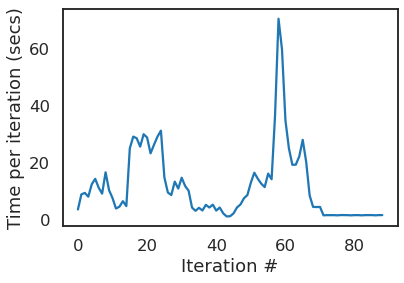

In [10]:
plt.plot(iter_timer)
plt.xlabel('Iteration #')
plt.ylabel('Time per iteration (secs)')

## Save to database

Finally, we're going to format the Tech tree to upload it to the database!

In [11]:
tech_df = pd.DataFrame.from_dict(tech_tree, orient='index')
tech_df = tech_df.rename_axis('id').reset_index()

tech_df.tail()

,id,depth,recipe
1413,835,68,"{'origActor': 836, 'origTarget': 834, 'newActo..."
1414,842,68,"{'origActor': -1, 'origTarget': 835, 'newActor..."
1415,839,69,"{'origActor': 0, 'origTarget': 842, 'newActor'..."
1416,841,69,"{'origActor': -1, 'origTarget': 839, 'newActor..."
1417,840,70,"{'origActor': 0, 'origTarget': 841, 'newActor'..."


In [12]:
tech_list = tech_df.to_dict('records')
print('%i items in tech tree' % len(tech_list))
print(*tech_list[-10:], sep='\n')

1418 items in tech tree
{'id': 830, 'depth': 64, 'recipe': {'origActor': -1, 'origTarget': 829, 'newActor': 0, 'newTarget': 830}}
{'id': 831, 'depth': 65, 'recipe': {'origActor': 812, 'origTarget': 830, 'newActor': 0, 'newTarget': 831}}
{'id': 832, 'depth': 66, 'recipe': {'origActor': 812, 'origTarget': 831, 'newActor': 0, 'newTarget': 832}}
{'id': 833, 'depth': 66, 'recipe': {'origActor': -1, 'origTarget': 832, 'newActor': 0, 'newTarget': 833}}
{'id': 834, 'depth': 67, 'recipe': {'origActor': 556, 'origTarget': 833, 'newActor': 0, 'newTarget': 834}}
{'id': 835, 'depth': 68, 'recipe': {'origActor': 836, 'origTarget': 834, 'newActor': 0, 'newTarget': 835}}
{'id': 842, 'depth': 68, 'recipe': {'origActor': -1, 'origTarget': 835, 'newActor': 0, 'newTarget': 842}}
{'id': 839, 'depth': 69, 'recipe': {'origActor': 0, 'origTarget': 842, 'newActor': 0, 'newTarget': 839}}
{'id': 841, 'depth': 69, 'recipe': {'origActor': -1, 'origTarget': 839, 'newActor': 0, 'newTarget': 841}}
{'id': 840, 'depth'

Connect to database:

Upload tech tree:

In [13]:
tech_col = ohol.tech_tree
tech_col.insert_many(tech_list)

Check that new collection has been added:

In [14]:
ohol.list_collection_names()

['old_svd',
 'old_jobmatrix',
 'tech_tree',
 'tech_tree_demo',
 'objects',
 'expanded_transitions',
 'transitions',
 'categories']

Debug: What items are missing from Tech tree?

In [20]:
all_objects = objects.id.values
found_objects = tech_df.id.values

missing_objects = np.setdiff1d(all_objects, found_objects)

print('%i objects still missing' % len(missing_objects))
print(*[obj_name(o) for o in missing_objects[250:350]], sep='\n')
print('...')

2745 objects still missing
Male012 C
Buried Grave - origGrave groundOnly
Marked Grave - origGrave
Wild Rose Seed - pink
Dry Planted Rose Seed - pink
Wet Planted Rose Seed - pink
Rose Sprout - pink
Cold Bowl with Rose Seed - pink
Cold Bowl with Stratified Rose Seed - pink
Stratified Rose Seed - pink
Wild Rose Seed - red
Wild Rose Seed - white
Cold Bowl with Rose Seed - red
Cold Bowl with Stratified Rose Seed - red
Cold Bowl with Rose Seed - white
Cold Bowl with Stratified Rose Seed - white
Stratified Rose Seed - red
Stratified Rose Seed - white
Pink Rose Bush
Dry Pink Rose Bush
Vigorous Pink Rose Bush
Pink Rose
Rose Hip - pink
Rose Seed - pink
Rose Seed - red
Rose Seed - white
Dry Planted Rose Seed - red
Wet Planted Rose Seed - red
Rose Sprout - red
Dry Planted Rose Seed - white
Wet Planted Rose Seed - white
Rose Sprout - white
Red Rose
White Rose
Rose Hip - red
Rose Hip - white
Dry White Rose Bush
Dry Red Rose Bush
Vigorous Red Rose Bush
Vigorous White Rose Bush
Red Rose Bush
White Ros

In [28]:
transitions[transitions.origTarget == 1015]

,_id,origActor,origTarget,newActor,newTarget,lastUseActor,lastUseTarget,prob
5445,607aef65cffb881ebaaff289,964,1015,964,1016,False,False,False


In [30]:
combinations(135, 1015)

0        False
1        False
2        False
3        False
4        False
         ...  
19440    False
19441    False
19442    False
19443    False
19444    False
Length: 19445, dtype: bool

In [31]:
obj_name(964)

'@ Fine Cutter'